# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf
import json
%matplotlib inline


In [2]:
#  Extracting Data
num_classes = 10
np.random.seed(133)
train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
#extra_filename = 'extra.tar.gz'-not downloaded extra for now

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  if not os.path.exists(root+'/digitStruct.mat'):
    print("digitStruct.mat is missing")
  return root+'/digitStruct.mat'
  
train_struct = maybe_extract(train_filename)
test_struct = maybe_extract(test_filename)
# extra_struct = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


In [3]:

inputs = idx2numpy.convert_from_file('train-images.idx3-ubyte')
labels = idx2numpy.convert_from_file('train-labels.idx1-ubyte')
dataset_size = 5000# just for initial stages
image_height = 28
image_width = 140
dataset = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)
print ("dataset:",dataset.shape)
data_labels = []#one-hot labels
data_labels_2=[]#integer labels for display etc
i = 0
w = 0
print ("inputs:",inputs.shape)
print ("labels from idx2numpy:",labels.shape)
print ("sample label from idx2numpy:",labels[0])
# need to convert labels to one-hot
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
labels_new = lb.fit_transform(labels)
print ("labels from converting idx2numpy to one-hot:",labels_new.shape)
print ("sample label from idx2numpy after conversion to one-hot:",labels_new[0])
while i < dataset_size:
    temp1 = np.hstack([inputs[w], inputs[w + 1], inputs[w + 2], inputs[w + 3], inputs[w + 4]])
    dataset[i, :, :] = temp1
    data_labels.append((labels_new[w], labels_new[w + 1], labels_new[w + 2], labels_new[w + 3], labels_new[w + 4]))
    data_labels_2.append((labels[w], labels[w + 1], labels[w + 2], labels[w + 3], labels[w + 4]))
    if i==0:
        print("One input's shape after concatenation:",temp1.shape)
        print("Corresponding label after concatenation:",data_labels[0])
    w += 5
    i += 1
print ("datatype of labels:",type(data_labels))
#to convert data_labels from list to array type
from numpy import array
data_labels=array(data_labels)
data_labels_2=array(data_labels_2)
print ("datatype of labels after conversion:",type(data_labels))
print ("shape of data labels2:",data_labels_2.shape)

dataset: (5000, 28, 140)
inputs: (60000, 28, 28)
labels from idx2numpy: (60000,)
sample label from idx2numpy: 5
labels from converting idx2numpy to one-hot: (60000, 10)
sample label from idx2numpy after conversion to one-hot: [0 0 0 0 0 1 0 0 0 0]
One input's shape after concatenation: (28, 140)
Corresponding label after concatenation: (array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))
datatype of labels: <class 'list'>
datatype of labels after conversion: <class 'numpy.ndarray'>
shape of data labels2: (5000, 5)


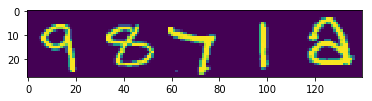

Label : [9 8 7 1 2]


In [4]:
import random
def displaySequence(n):
    fig=plt.figure()
    plt.imshow(dataset[n])
    plt.show()
    print ('Label : {}'.format(data_labels_2[n]))
displaySequence(random.randint(0, dataset_size))    

C:\Users\dinkar\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


1


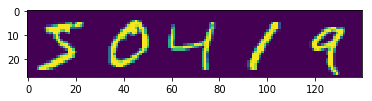

Label : [5 0 4 1 9]
(5000, 28, 140) (5000, 5)


In [5]:

from sklearn.cross_validation import train_test_split
y = data_labels_2
X = dataset
X_train_old,X_test_old,y_train,y_test = train_test_split(X,y,test_size=0.3)
print(data_labels_2[0,3])
displaySequence(0)   
print (X.shape,y.shape)

In [6]:
# normalize image in range of -1 and 1.
X_train = X_train_old.astype('float32') / 128.0 - 1
X_test = X_test_old.astype('float32') / 128.0 - 1
print(X_train.shape)


(3500, 28, 140)


In [7]:
train_data,labels_new=X_train,y_train
valid_data,labels_new_valid=X_test,y_test

print ('Train data:', train_data.shape,', Train labels:', labels_new.shape)
print ('Validation data:', valid_data.shape,', Validation labels:', labels_new_valid.shape)

Train data: (3500, 28, 140) , Train labels: (3500, 5)
Validation data: (1500, 28, 140) , Validation labels: (1500, 5)


In [8]:
def reformat(dataset, labels):
  dataset = dataset.reshape((-1, 28, 28*5, 1)).astype(np.float32)
  return dataset, labels
train_data,labels_new = reformat(X_train, y_train)
print ('Training set after reshape:', train_data.shape, labels_new.shape)
valid_data,labels_new_valid = reformat(X_test, y_test)

Training set after reshape: (3500, 28, 140, 1) (3500, 5)


In [9]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')


In [10]:
def accuracy(predictions, labels):
    #print (np.argmax(predictions, 2).T)
    #print (labels)
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [11]:
graph = tf.Graph()

with graph.as_default():
    
    # placeholders for input data batch_size x 28 x 140 x 1 =
    x = tf.placeholder(tf.float32, shape=[None, 28, 140, 1])
    y_ = tf.placeholder(tf.int32, shape=[None, 5])
    tf_X_test = tf.constant(X_test)
    
    def model(data):
        # Conv Layer 1: with 32 filters of size 5 x 5 
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        x_image = tf.reshape(data, [-1, 28, 28, 1])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
        # Pooling layer with 2 x 2 strides
        h_pool1 = max_pool_2x2(h_conv1)
    
        # Conv Layer 2:  with 64 filters of size 5 x 5 
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    
        # Second Pooling Layer
        h_pool2 = max_pool_2x2(h_conv2)

        # FC layer-pool matrix has to be flattened before feeding it here
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) 
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
        # Readout layer
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        return tf.matmul(h_fc1, W_fc2) + b_fc2
    
    logits1 = model(x[:,:,0:28])
    logits2 = model(x[:,:,28:56])
    logits3 = model(x[:,:,56:84])
    logits4 = model(x[:,:,84:112])
    logits5 = model(x[:,:,112:140])
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1,labels=y_[:,0]))+\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y_[:,1]))+\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y_[:,2]))+\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y_[:,3]))+\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y_[:,4]))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    train_prediction = tf.pack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                            tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
    test_prediction=tf.pack([tf.nn.softmax(model(tf_X_test[:,:,0:28])),\
                         tf.nn.softmax(model(tf_X_test[:,:,28:56])),\
                         tf.nn.softmax(model(tf_X_test[:,:,56:84])),\
                         tf.nn.softmax(model(tf_X_test[:,:,84:112])),\
                         tf.nn.softmax(model(tf_X_test[:,:,112:140]))])


In [12]:

batch_size = 16
num_steps = 2000
with tf.Session(graph=graph) as session:
    session.run(tf.initialize_all_variables())
    for i in range(num_steps):
        offset = (i * batch_size) % (labels_new.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :]
        batch_labels = labels_new[offset:(offset + batch_size), :]
        feed_dict = {x: batch_data, y_: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if i%200 == 0:
            print('Minibatch loss at step %d: %f' % (i, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
   
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), labels_new_valid))        
            


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 67.711861
Minibatch accuracy: 12.5%
Minibatch loss at step 200: 1.358691
Minibatch accuracy: 90.0%
Minibatch loss at step 400: 0.677202
Minibatch accuracy: 97.5%
Minibatch loss at step 600: 0.380440
Minibatch accuracy: 97.5%
Minibatch loss at step 800: 0.229144
Minibatch accuracy: 98.8%
Minibatch loss at step 1000: 0.097199
Minibatch accuracy: 100.0%
Minibatch loss at step 1200: 0.046017
Minibatch accuracy: 100.0%
Minibatch loss at step 1400: 0.058880
Minibatch accuracy: 100.0%
Minibatch loss at step 1600: 0.025371
Minibatch accuracy: 100.0%
Minibatch loss at step 1800: 0.045070
Minibatch accuracy: 100.0%
Test accuracy: 8.6%


### Question 1
_What approach did you take in coming up with a solution to this problem?_

I used a convolutional neural network for this problem, since it has been touted as one of the best methods for image classification.

First, MNIST dataset consists only of single digits. A dataset containing five digits had to be created. For this first it was required to convert the dataset from idx to numpy format. This was done with the help was of a package called idx2numpy (https://pypi.python.org/pypi/idx2numpy), information regarding which was obtained from this thread in forums:https://discussions.udacity.com/t/questions-about-step-1/204239.

For feeding the data into the CNN, my theory was that since each element in dataset consists of 5 28 x 28 images stacked together side-to-side, at a time, widthwise only 28 pixels of the image will be fed to the model,(example: from 0 to 28). Since total width is 140, 5 classifiers will have to to be used and their cumulative loss function will be considered.

This automatically implied that 5 labels will have to be used as well, one corresponding to each digit. After familiarizing myself with the tensorflow syntax from this youtube video of a Stanford lecture:https://www.youtube.com/watch?v=l6K-MFgIEjc, I got to work.

Initially, I was thinking of one-hot encoding these labels, but then I came across this link :http://stackoverflow.com/questions/37312421/tensorflow-whats-the-difference-between-sparse-softmax-cross-entropy-with-logi
 and decided to use sparse_softmax_cross_entropy_with_logits function for its convenience.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_


 First comes the input data with dimensions batch_size x 28 x 140 x 1 .
 
Then there is first convolution layer with 32 filters of size 5 x 5 that moves over the input data and gives a dot product of the locally connected region and its weights.Its depth can be specified as a hyperparameter.

Activation function used is RELU function as it helps us to predict non-linearity. Size of the volume is not changed.

Then a maxpooling layer is used with strides (2 x 2) to perform a downsampling operation along the height and width.

Same sequence(conv-Relu-pool) is repeated once again but with different depth,i.e, 64.

Finally, a fully-connected layer and a readout layer is present. They return an array of size [1x1x10], where each of the 10 numbers correspond to a number between 0-9.

Optimization algorithm used was a GradientDescentOptimizer with a learning rate which was initially 0.05 and later changed to 0.01.


Reference- ‘Deep MNIST for experts’ tutorial present on the Tensorflow website.https://www.tensorflow.org/get_started/mnist/pros


### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

Model was trained by synthetic dataset generated by combining 5 consecutive images present in the MNIST dataset at a time. Random sequences of images were not chosen as aim was to create more number of examples with more heteroogeneity and it was seen that consecutive images have a less probability of being similar.

For this first it was required to convert the dataset from idx to numpy format. This was done with the help was of a package called idx2numpy (https://pypi.python.org/pypi/idx2numpy), information regarding which was obtained from this thread in forums:https://discussions.udacity.com/t/questions-about-step-1/204239. This class, after conversion of data to numpy format, employs the numpy.hstack method to generate sequences of a given length.

Model training was done using sklearn's train_test_split module, with 70% of data allotted to training set and rest to testing set.
X_train_old,X_test_old,y_train,y_test = train_test_split(X,y,test_size=0.3).

Cumulative loss function that was used consisted of 5 individual softmax_cross_entropy_with_logits functions. Optimizer function was GradientDescentOptimizer.

Example of generated image along with the code is given above.

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
import h5py

### Your code implementation goes here.
### Feel free to use as many code cells as needed.

print('Creating dictionary of bounding boxes...')
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        #if n==10 or n==2:
            #print("name is:",''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value]))
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        #print("bboxhelper prints:",attr)    
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        #print ("height is:",bbox['height'])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        #print ("label is:",bbox['label'])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        #print ("left is:",bbox['left'])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        #print("getalldigitsstructure returns:",self.getDigitStructure(1) )
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
    
print("Successfully created dictionary of bounding boxes!")

Creating dictionary of bounding boxes...
Successfully created dictionary of bounding boxes!


In [14]:
train_folders = 'train'
test_folders = 'test'

fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

In [15]:
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

In [16]:
from PIL import Image
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:]
print(np.amax(train_imsize[:,0]), np.amax(train_imsize[:,1]))
print(np.amin(train_imsize[:,0]), np.amin(train_imsize[:,1])) 

876.0 501.0
25.0 12.0


In [17]:
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]
print(np.amax(test_imsize[:,0]), np.amax(test_imsize[:,1]))
print(np.amin(test_imsize[:,0]), np.amin(test_imsize[:,1]))    

1083.0 516.0
31.0 13.0


In [18]:
import PIL.Image as Image

def generate_dataset(data, folder):

    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    labels = np.ones([len(data),6], dtype=int) * 10
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: labels[i,j+1] = 0
            #else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])

        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)


(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)


In [31]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]

In [38]:
#Our model is setup in this way
#7-layer CNN.
#C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
#S2: sub-sampling layer, batch_size x 14 x 14 x 16
#C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
#S4: sub-sampling layer, batch_size x 5 x 5 x 32
#C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64 
#Dropout F6: fully-connected layer, weight size: 64 x 16 
#Output layer, weight size: 16 x 10

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_test_dataset = tf.constant(test_dataset)
    tf_captured_dataset=tf.constant(reshaped2)
    tf_captured_dataset=tf.cast(tf_captured_dataset,tf.float32)
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  

    def model(data, keep_prob, shape):
        conv = tf.nn.conv2d(data,layer1_weights, [1,1,1,1],padding='VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.8, shape)
    # Define loss function.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
    # Optimizer.
    global_step = tf.Variable(0)
    #learning rate with exponential decay.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.9) 
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
    
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
    captured_prediction = tf.pack([tf.nn.softmax(model(tf_captured_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_captured_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_captured_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_captured_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_captured_dataset, 1.0, shape)[4])])
    saver = tf.train.Saver()

In [39]:
num_steps = 1000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 100 == 0): 
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
    # print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), validation_labels[:,1:6]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  print('Accuracy on captured images:%.1f%%'%accuracy(captured_prediction.eval(),captured_labels[:,1:6]))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 15.809157
Minibatch accuracy: 24.4%
Minibatch loss at step 100: 6.303002
Minibatch accuracy: 59.7%
Minibatch loss at step 200: 5.727000
Minibatch accuracy: 63.4%
Minibatch loss at step 300: 6.092128
Minibatch accuracy: 60.9%
Minibatch loss at step 400: 5.963926
Minibatch accuracy: 61.2%
Minibatch loss at step 500: 5.679409
Minibatch accuracy: 64.7%
Minibatch loss at step 600: 5.862023
Minibatch accuracy: 61.2%
Minibatch loss at step 700: 5.902161
Minibatch accuracy: 63.8%
Minibatch loss at step 800: 5.705307
Minibatch accuracy: 65.9%
Minibatch loss at step 900: 5.819355
Minibatch accuracy: 64.7%
Test accuracy: 65.8%
Accuracy on captured images:52.7%


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

Training and testing datasets were first downloaded from the Stanford website.

Along with the data, one more file called as Digitstruct is given. I learnt about the working of DigitStructFile from a thread in Udacity discussion forums:https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657 . Information regarding parameters like left, height, width, label etc of the image that is present in the digitstruct file, is helpful in image classification. This info was extracted by the help of h5py module and class DigitStructFile, which returns a dictionary of data about a particular bounding box in the image.

Again , a CNN model model was used as in the synthetic MNIST dataset, but with the addition of a dropout layer with a probability of 0.9. Similar to MNIST problem, 5 separate classifiers were used. However, number of labels possible in a particular position was 11, as it could be possible that there was no labels present. Optimizer was changed from GradientDescent to AdamOptimizer with an exponentially decaying rate.

The model does not perform as well on a realistic dataset as compared to the synthetic dataset. Batch size has been increased to 64 and an additional dropout layer has been added. Still, the accuracy hovers around 62 to 65% for training set for different settings of learning rates. I think this can be improved by increasing the training examples and/or training steps, but even these existing claculations take up a lot of time on my system.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

    a) First of all, the learning rate of the optimizer was varied between 0.5 to 0.01.
    b)Then an exponentially decaying alpha was chosen instead of a constant one.
    c) Gradient descent optimizer was discarded in the favour of the Adam optimizer.
    d) Additional dropout layer was added as a part of a Hit and Trial approach.
    e) Batch size was varied between 16, 32 and 64.
    The model sometimes gave worse performance when learning rate was increased. 


### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

Initial results with realistic dataset gave a train accuracy of 18.8% and test accuracy of around 9 % after 2000 iterations.
Final results give a train accuracy of around 64% and test accuracy of 65% after 1000 iterations.

I think that the model is performing reasonably well , given that it is severely limited by my PC’s computational power and I am unable to run more number of iterations due to overheating problems and excessive time taken for their computation.


----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [40]:
def to_grayscale(rgb): #convert to grayscale
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [22]:
import matplotlib.image as img
import glob
from scipy import misc
image_list = []
for path in glob.glob("captured/*.jpg"):
    image = img.imread(path)
    image = to_grayscale(image)
    image_list.append(image)


In [23]:
import matplotlib.pyplot as plt
def display_captured(n):
    fig=plt.figure()
    plt.imshow(image_list[n], cmap='gray')
    plt.show()

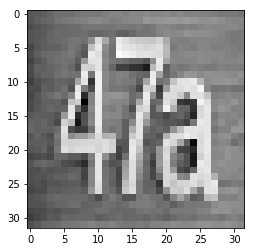

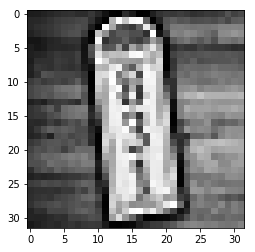

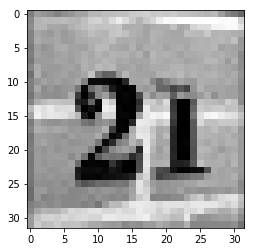

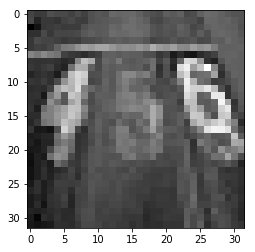

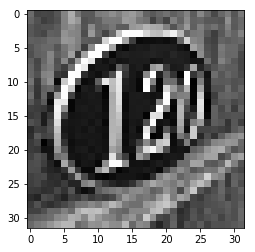

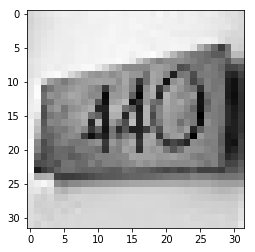

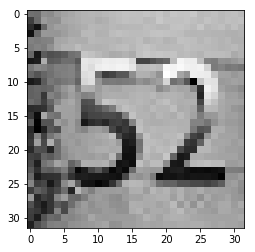

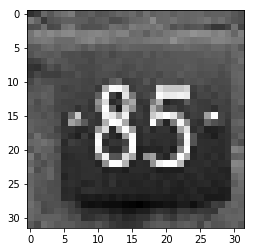

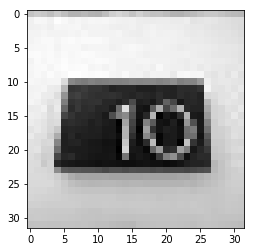

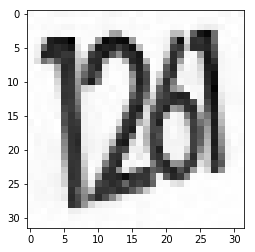

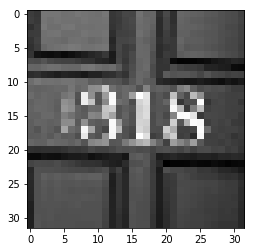

In [24]:
for i in range(len(image_list)):
    display_captured(i)

In [25]:
print(image_list[0].shape)#shape of one image before reshaping

(32, 32)


In [41]:
reshaped=[]
for image in image_list:
    image = image.reshape(image.shape[1],32, 1)
    image.astype(float)
    reshaped.append(image)
reshaped=np.array(reshaped)
print(reshaped.shape)
reshaped2= reshaped.reshape(reshaped.shape[0], 32, 32, 1)
print(reshaped2.shape)    

(11, 32, 32, 1)
(11, 32, 32, 1)


In [30]:
captured_labels=np.array([[2,4,7,10,10,10],[3,4,5,6,10,10],[3,1,2,0,10,10],[3,4,4,0,10,10],[2,5,2,10,10,10],[2,8,5,10,10,10],
                        [2,1,0,10,10,10],[4,1,2,6,1,10],[3,3,1,8,10,10],[3,8,3,1,10,10],[2,2,1,10,10,10]])
print (captured_labels.shape)

(11, 6)


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_


 Five images have been shown in the code cells above.
 
Some of them are surrounded by edges which maybe mistaken for other digits. Others are tilted at an angle. All digits are not exactly horizontal. There is also an interplay of light and darkness in some digits, which makes it more difficult to classify them.


### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

The algorithm is not performing as well on the captured digits, maybe due to reasons given above. It gives an accuracy of 52%.(accuracy for captured images calculated in the same code cell as that of train dataset)

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [207]:
#USING REGRESSION TO PREDICT BOUNDING BOXES PARAMETERS FOR AN IMAGE
#We will predict parameters for one digit in an image at a time
def return_params(train_data,train_dataset,c,size):#returns parameters of cth position digit in an image
    train_dataset_2=np.zeros(shape=(size,32,32,1))
    left_label=[]
    top_label=[]
    width_label=[]
    height_label=[]
    y = []
    k=0
    for r in range(size):
        j= len(train_data[r]['boxes']) # will give no of digits of ith image
        if c <= j-1:# the image does have cth digit
            train_dataset_2[k]=train_dataset[r]# removing that image from train_Dataset
            k+=1
            #calculating bounding boxes only for the digit at cth position in each image
            left_label.append(train_data[r]['boxes'][c]['left'])
            top_label.append(train_data[r]['boxes'][c]['top'])
            width_label.append(train_data[r]['boxes'][c]['width'])
            height_label.append(train_data[r]['boxes'][c]['height'])

    y.append(left_label)
    y.append(top_label)
    y.append(width_label)
    y.append(height_label)
    y = np.array(y)
    y = y.T
    p=y.shape[0]
    train_dataset_3=train_dataset_2[0:p,:,:,:]    # dataset will only extend till the number of labels
    return y,train_dataset_3

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
size=10000
for i in range(5): # for each digit in image 
    y,train_dataset_2=return_params(train_data,train_dataset[0:size,:,:,:],i,size)
    revised_size=train_dataset_2.shape[0]
    print('size of train dataset for digit at %d position is %d'%(i,revised_size))
    #flattening images
    train_data_flt=np.ndarray(shape=(revised_size,32*32))
    for r in range(revised_size):
        train_data_flt[r]=train_dataset_2[r].flatten()
    print ('shape of flattened training set:%d'%(train_data_flt.shape[1]))    
    X_train, X_test, y_train, y_test = train_test_split(train_data_flt, y, train_size=0.75, random_state=1)
    #print(X_train.shape)
    #print(y_train.shape)
    #print(X_test.shape)
    #print(y_test.shape)
    rgr = MultiOutputRegressor(GradientBoostingRegressor(max_depth=5, random_state=0)).fit(X_train, y_train)
    #manually inspecting if bbox parameters are similar
    print("for digit at %d position,predicted bbox parameters: "%i)
    y_pred = rgr.predict(X_test)
    print(y_pred[0])
    print("actual bbox parameters:")
    print(y_test[0])
    #inspecting based on accuracy
    accuracy = rgr.score(X_test, y_test)
    print("for digit at %d position, accuracy is %.2f "%(i,accuracy))

10000
size of train dataset for digit at 0 position is 10000
shape of flattened training set:1024
for digit at 0 position,predicted bbox parameters: 
[ 90.94211076  20.52590887  22.0779668   42.81627176]
actual bbox parameters:
[ 62.  16.  30.  58.]
for digit at 0 position, accuracy is 0.18 
8483
size of train dataset for digit at 1 position is 8483
shape of flattened training set:1024
for digit at 1 position,predicted bbox parameters: 
[ 58.12948993   2.71701042  18.62134406  31.99920266]
actual bbox parameters:
[ 42.   1.   8.  21.]
for digit at 1 position, accuracy is 0.21 
3069
size of train dataset for digit at 2 position is 3069
shape of flattened training set:1024
for digit at 2 position,predicted bbox parameters: 
[ 48.44579711  16.28253941   7.76501376  24.99502495]
actual bbox parameters:
[ 40.   4.   7.  21.]
for digit at 2 position, accuracy is 0.19 
449
size of train dataset for digit at 3 position is 449
shape of flattened training set:1024
for digit at 3 position,predict

[ 84.  10.  13.  24.]


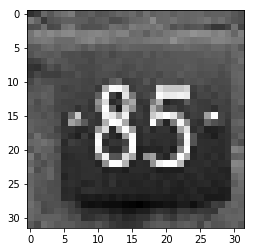

In [221]:
#testing for captured images
captured_data_flt=np.ndarray(shape=(11,32*32))# eleven images are captured
for r in range(11):
    captured_data_flt[r]=reshaped2[r].flatten()
captured_pred = rgr.predict(captured_data_flt)
accuracy_captured = rgr.score(X_test, y_test)
print(captured_pred[8])
display_captured(7)

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

The model localizes numbers in the realistic dataset with an accuracy of around 20% for the first three digits(starting from left), while accuracy was around 12% for the fourth digit from the left as there are considerably less training examples with 4 digits. By a similar reasoning, accuracy for fifth digit is zero as only 2 images are having 5 digits in our training set.   Classification results are better with localization included.
    I only used 10000 examples for training as the model was taking many hours to get trained due to computational limitations. I have observed a marked improvement over the earlier case when I was taking only 2000 examples as then accuracy was hovering between 0 to 5% for all digits. I think that by increasing the number of training examples and increasing the max_dapth of the regressor, accuracy will increase. However,a much better computational power will be required for that.  

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

The model is not calculating the bounding boxes with even a reasonable accuracy for captured images, maybe because of reasons given in question 10. An example has been provided in the above code cells.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.